<a href="https://colab.research.google.com/github/monicafar147/To-vaccinate-or-not-/blob/EDA/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the past decade, tracking health trends using social media data has shown great promise, due to:
-  a powerful combination of massive adoption of social media around the world
-  increasingly potent hardware and software that enables us to work with these new big data streams. 

At the same time, many challenging problems have been identified:
1. There is often a mismatch between how rapidly online data can change, and how rapidly algorithms are updated, which means that there is limited reusability for algorithms trained on past data as their performance decreases over time.
2. Much of the work is focusing on specific issues during a specific past period in time, even though public health institutions would need flexible tools to assess multiple evolving situations in real time. 
3. Most tools providing such capabilities are proprietary systems with little algorithmic or data transparency, and thus little buy-in from the global public health and research community. 

The objective of this challenge is to develop a machine learning model to assess if a twitter post that is related to vaccinations is
- positive
- neutral
- negative.

Tweets have been classified as
-  pro-vaccine (1)
-  neutral (0) 
-  anti-vaccine (-1). 
The tweets have had usernames and web addresses removed.

# Importing the data

In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv("https://raw.githubusercontent.com/monicafar147/To-vaccinate-or-not-/master/Train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/monicafar147/To-vaccinate-or-not-/master/Test.csv")

Variable definition
- tweet_id: Unique identifier of the tweet
- safe_tweet: Text contained in the tweet. Some sensitive information has been removed like usernames and urls
- label: Sentiment of the tweet (-1 for negative, 0 for neutral, 1 for positive)
- agreement: The tweets were labeled by three people. Agreement indicates the percentage of the three reviewers that agreed on the given label. You may use this column in your training, but agreement data will not be shared for the test set.

In [2]:
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [3]:
# checking null values
unique = [row for row in train['tweet_id'].unique()]
print("Number of unique values")
print(train['tweet_id'].nunique())
print("\nTotal number of values")
print(len(train['tweet_id']))
print("\nNumber of null values:\n" + str(train.isnull().sum()))

Number of unique values
10001

Total number of values
10001

Number of null values:
tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64


- There is 1 label that contains a null value
- There are 2 agreements that contain a null value

In [4]:
train.dropna(inplace=True)

In [5]:
# checking null values
unique = [row for row in train['safe_text'].unique()]
print("Number of unique values")
print(train['tweet_id'].nunique())
print("\nTotal number of values")
print(len(train['tweet_id']))
print("\nNumber of null values:\n" + str(train.isnull().sum()))

Number of unique values
9999

Total number of values
9999

Number of null values:
tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64


In [6]:
grouped = train[['label', 'safe_text',]].groupby('label').count()

In [7]:
grouped

,safe_text
label,
-1.0,1038
0.0,4908
1.0,4053


Looks a lot better!!!

In [8]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


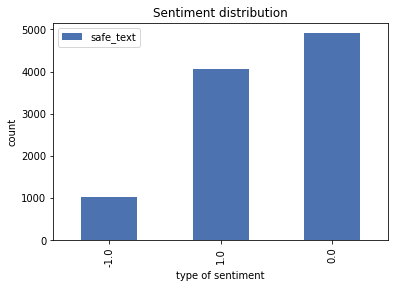

In [9]:
grouped.sort_values('safe_text', ascending=True).plot(kind='bar')
plt.title('Sentiment distribution')
plt.ylabel('count')
plt.xlabel('type of sentiment')
plt.show()

The data is unbalanced.

To counter this the following strategies can be used
- cross validation
- use small test size
- use stratify in train-test split
- use SMOTE
- up-sampling of data
- down-sampling of data


In [10]:
train['agreement'] = train['agreement'].round(2)

Text(0.5, 1.0, 'Distribution of agreement values')

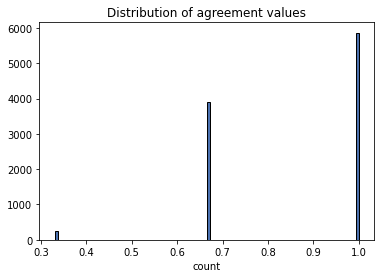

In [11]:
#looking at agreement column
plt.hist(train['agreement'], bins = 100, edgecolor = 'k')
plt.xlabel('count') 
plt.title('Distribution of agreement values')

In [12]:
agreed = train[['agreement', 'safe_text',]].groupby('agreement').count()
agreed

,safe_text
agreement,
0.33,239
0.67,3894
1.00,5866


To improve the model accuracy
- use agreement more than 0.3
- only use 100% agreement

In [13]:
# Dropping rows where agreement is not 1.00
data = train[train['agreement'] == 1.00]

In [14]:
data

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0
...,...,...,...,...
9993,CMG700N8,One half hour? Isa that it? #pdx #mmr,0.0,1.0
9995,X8B650Z4,I'll say I am glad Mom gave me the MMR vaccina...,1.0,1.0
9996,IU0TIJDI,Living in a time where the sperm I used to was...,1.0,1.0
9998,ST3A265H,Interesting trends in child immunization in Ok...,0.0,1.0


# EDA

In [15]:
from nltk.tokenize import TweetTokenizer

In [16]:

def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary 
        with each word as a key, and the value represents the number of 
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [ ]:
tokeniser = TweetTokenizer()
data['tokens'] = data['safe_text'].apply(tokeniser.tokenize)
sentiment_labels = list(set(data['label'].values))
sentiment = {}
for sent in sentiment_labels:
    df = data.groupby('label')
    sentiment[sent] = {}
    for row in df.get_group(sent)['tokens']:
        sentiment[sent] = bag_of_words_count(row, sentiment[sent])

In [18]:
anti = {key: value for key, value in sorted(sentiment[-1].items(), key=lambda item: item[1], reverse=True)}
neutral = {key: value for key, value in sorted(sentiment[0].items(), key=lambda item: item[1], reverse=True)}
pro = {key: value for key, value in sorted(sentiment[1].items(), key=lambda item: item[1], reverse=True)}

In [19]:
from string import punctuation
import nltk
nltk.download(['stopwords','punkt'])
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
random = set(stopwords.words('english') + list(punctuation)+["<user>","<url>"])

In [26]:
# anti
anti_keys = [key for key in anti.keys() if key not in random]
anti_values = [value[1] for value in anti.items() if value[0] not in random]
# neutral
neutral_keys = [key for key in neutral.keys() if key not in random]
neutral_values = [value[1] for value in neutral.items() if value[0] not in random]
# pro
pro_keys = [key for key in pro.keys() if key not in random]
pro_values = [value[1] for value in pro.items() if value[0] not in random]


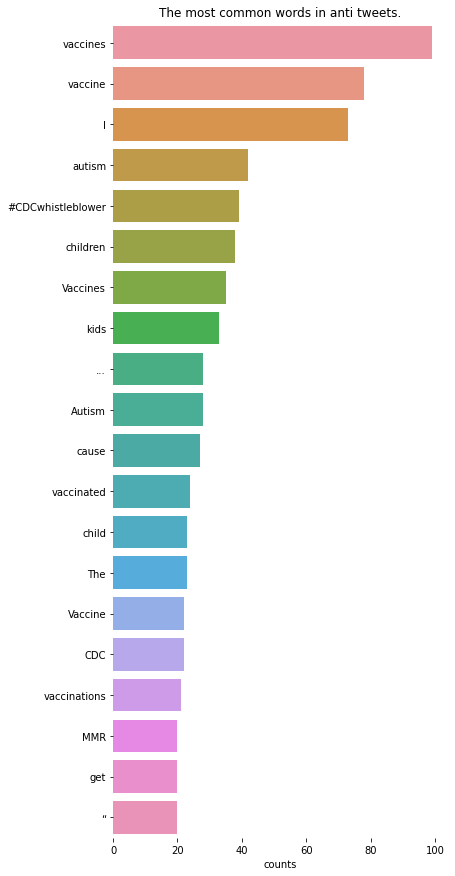

In [27]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(anti_values[0:20],anti_keys[0:20])
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The most common words in anti tweets.')
sns.despine(left=True, bottom=True)

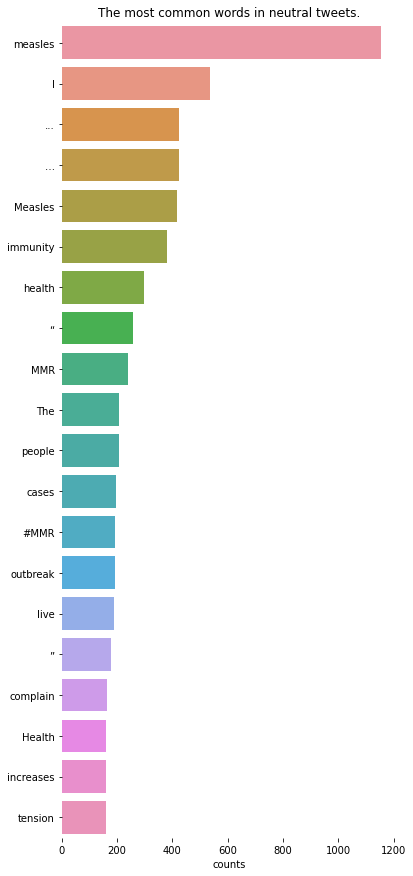

In [28]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(neutral_values[0:20],neutral_keys[0:20])
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The most common words in neutral tweets.')
sns.despine(left=True, bottom=True)

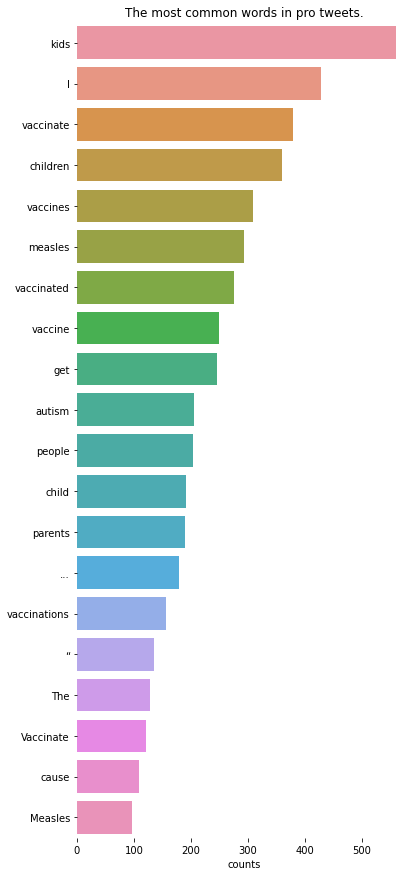

In [29]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(pro_values[0:20],pro_keys[0:20])
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="counts")
ax.title.set_text('The most common words in pro tweets.')
sns.despine(left=True, bottom=True)

Look into the words user and URL

In [73]:
anti_tweets = data['safe_text'][data['label']==-1]
neutral_tweets = data['safe_text'][data['label']==0]
pro_tweets = data['safe_text'][data['label']==1]

In [74]:
anti_hashtags = anti_tweets.str.extractall(r'(\#\w+)')[0].value_counts()
neutral_hashtags = neutral_tweets.str.extractall(r'(\#\w+)')[0].value_counts()
pro_hashtags = pro_tweets.str.extractall(r'(\#\w+)')[0].value_counts()

In [75]:
print("\033[1mAnti hastags\033[0m\n" + str(anti_hashtags))

Anti hastags
#CDCwhistleblower    39
#autism              14
#vaccine             10
#vaccines            10
#VaxTruth             8
                     ..
#GuillamBared         1
#timminchin           1
#Vaxxed               1
#African              1
#CDCwhisteblower      1
Name: 0, Length: 126, dtype: int64


In [78]:
print("\033[1mNeutral hastags\033[0m\n" + str(neutral_hashtags))

Neutral hastags
#MMR            193
#mmr            132
#measles        101
#dc              42
#dj              40
               ... 
#MIKEYMOUSE       1
#modspace         1
#disneyworld      1
#rumorsdc         1
#TheCampaign      1
Name: 0, Length: 1164, dtype: int64


In [79]:
print("\033[1mPro hastags\033[0m\n" + str(pro_hashtags))

Pro hastags
#vaccineswork         88
#measles              51
#vaccinate            33
#VaccinateYourKids    26
#vaccines             24
                      ..
#telemundohouston      1
#child                 1
#Kyrgyzstan            1
#Tetanus               1
#needles               1
Name: 0, Length: 580, dtype: int64
